In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from abc import ABC, abstractmethod
from typing import Dict, Any
from sklearn.datasets import load_diabetes
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    classification_report,
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    make_scorer
)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [3]:
data = pd.read_csv('D:/dataset/diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


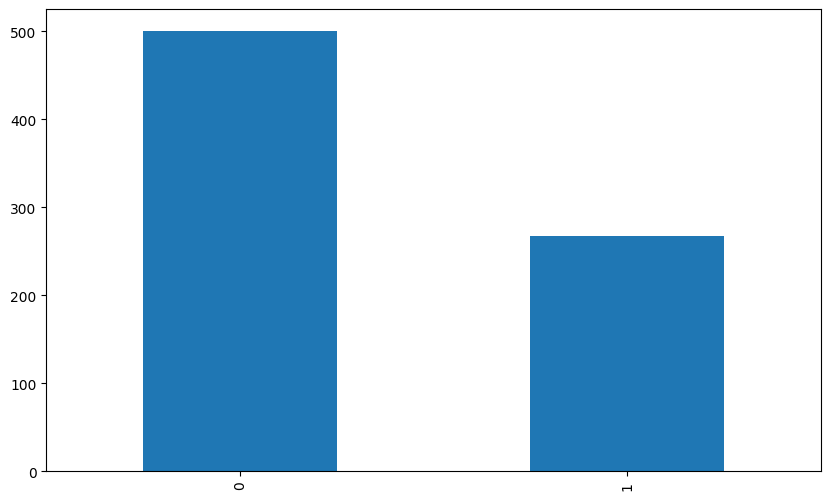

In [6]:
plt.figure(figsize=(10, 6))
data['Outcome'].value_counts().plot(kind='bar')
plt.show()

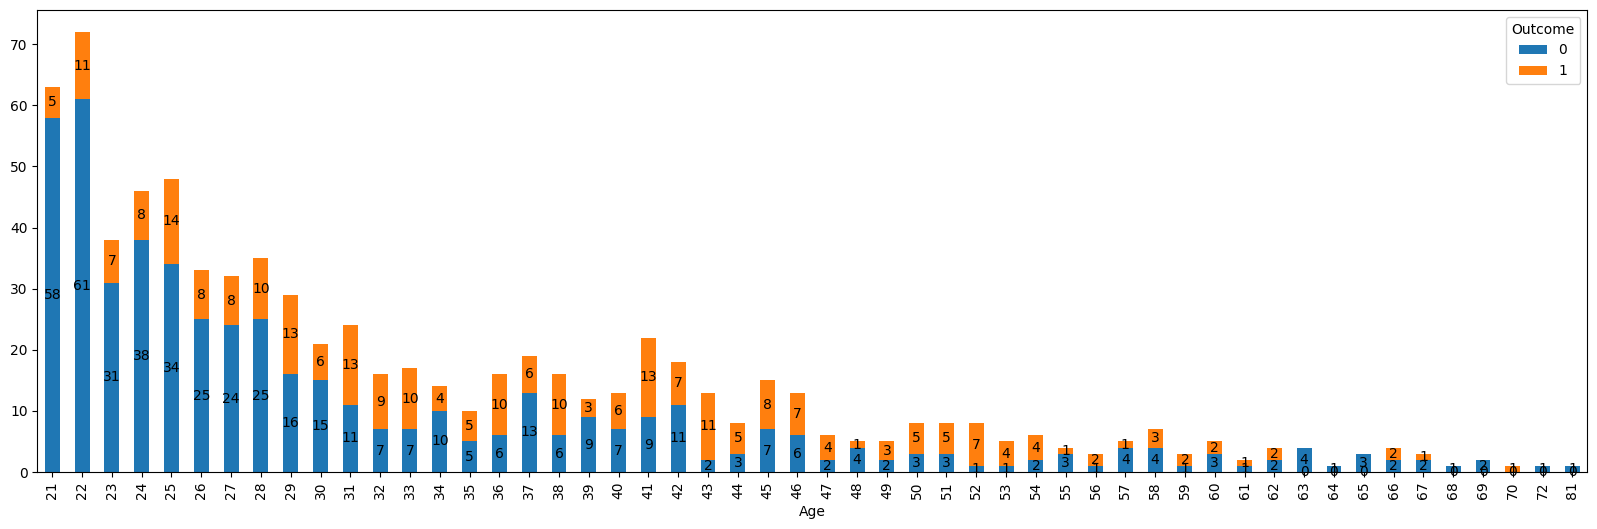

In [7]:
age_outcome_count = data.groupby('Age')['Outcome'].value_counts().unstack().fillna(0)
ax = age_outcome_count.plot(kind='bar', stacked=True, figsize=(20, 6))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

<Axes: xlabel='Outcome', ylabel='Pregnancies'>

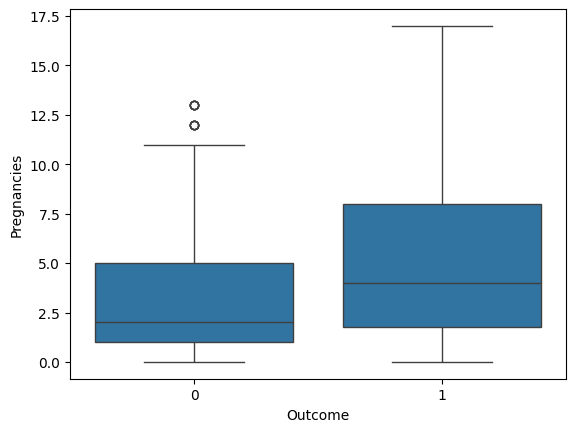

In [8]:
sns.boxplot(x='Outcome', y='Pregnancies', data=data)

<Axes: xlabel='Outcome', ylabel='BloodPressure'>

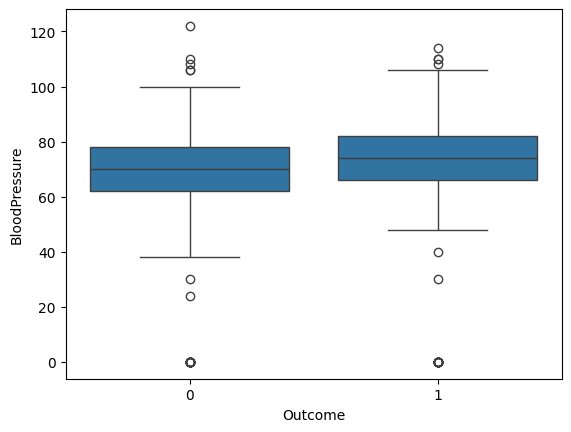

In [9]:
sns.boxplot(x='Outcome', y='BloodPressure', data=data)

<Axes: xlabel='Outcome', ylabel='Glucose'>

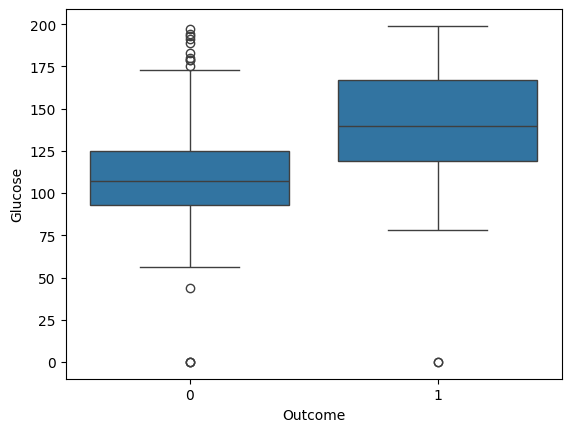

In [10]:
sns.boxplot(x='Outcome', y='Glucose', data=data)

<Axes: xlabel='Outcome', ylabel='SkinThickness'>

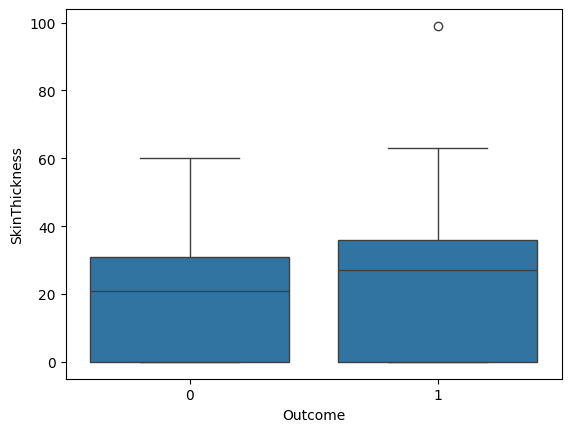

In [11]:
sns.boxplot(x='Outcome', y='SkinThickness', data=data)

<Axes: xlabel='Outcome', ylabel='Insulin'>

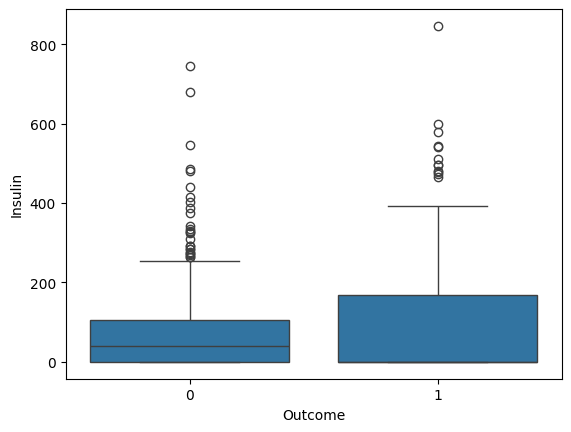

In [12]:
sns.boxplot(x='Outcome', y='Insulin', data=data)

<Axes: >

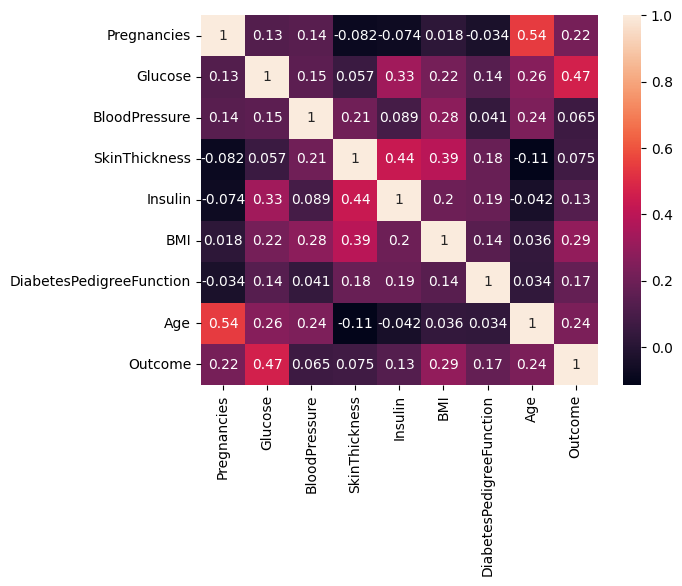

In [13]:
sns.heatmap(data.corr(), annot=True)

In [14]:
class KNN(ABC):
    """Base class for KNN implementations"""

    def __init__(self, K: int = 3, metric: str = 'minkowski', p: int = 2) -> None:
        """Initializer function. Ensure that input parameters are compatible.

        Inputs:
        K -> integer specifying the number of neighbours to consider
        metric -> string to indicate the distance metric to use (valid entries are 'minkowski' or 'cosine')
        p -> order of the minkowski metric (valid only when distance == 'minkowski')
        """

        # check distance is a valid entry
        valid_distance = ['minkowski', 'cosine']
        if metric not in valid_distance:
            msg = "Entered value for metric is not valid. Pick one of {}".format(valid_distance)
            raise ValueError(msg)

        # check minkowski p parameter
        if (metric == 'minkowski') and (p <= 0):
            msg = "Entered value for p is not valid. For metric = 'minkowski', p >= 1"
            raise ValueError(msg)

        # store/initialize input parameters
        self.K = K
        self.metric = metric
        self.p = p
        self.X_train = np.array([])
        self.y_train = np.array([])

    def __del__(self) -> None:
        """Destructor function."""
        del self.K
        del self.metric
        del self.p
        del self.X_train
        del self.y_train

    def __minkowski(self, x: np.array) -> np.array:
        """
        Private function to compute the minkowski distance between point x and the training data X

        Inputs:
        x -> numpy data point of predictors to consider

        Outputs:
        np.array -> numpy array of the computed distances
        """
        return np.power(np.sum(np.power(np.abs(self.X_train - x), self.p), axis=1), 1 / self.p)

    def __cosine(self, x: np.array) -> np.array:
        """
        Private function to compute the cosine distance between point x and the training data X

        Inputs:
        x -> numpy data point of predictors to consider

        Outputs:
        np.array -> numpy array of the computed distances
        """
        return 1 - (np.dot(self.X_train, x) / (np.linalg.norm(x) * np.linalg.norm(self.X_train, axis=1)))

    def __distances(self, X: np.array) -> np.array:
        """
        Private function to compute distances to each point x in X[x,:]

        Inputs:
        X -> numpy array of points [x]

        Outputs:
        D -> numpy array containing distances from x to all points in the training set.
        """
        # cover distance calculation
        if self.metric == 'minkowski':
            D = np.apply_along_axis(self.__minkowski, 1, X)
        elif self.metric == 'cosine':
            D = np.apply_along_axis(self.__cosine, 1, X)
        # return computed distances
        return D

    @abstractmethod
    def _generate_predictions(self, idx_neighbours: np.array) -> np.array:
        """Protected function to compute predictions from the K nearest neighbours"""
        pass

    def fit(self, X: np.array, y: np.array) -> None:
        """
        Public training function for the class. It is assumed input X has been normalized.

        Inputs:
        X -> numpy array containing the predictor features
        y -> numpy array containing the labels associated with each value in X
        """
        # store training data
        self.X_train = np.copy(X)
        self.y_train = np.copy(y)

    def predict(self, X: np.array) -> np.array:
        """
        Public prediction function for the class. It is assumed input X has been normalized in the same fashion as the input to the training function

        Inputs:
        X -> numpy array containing the predictor features

        Outputs:
        y_pred -> numpy array containing the predicted labels
        """
        # ensure we have already trained the instance
        if (self.X_train.size == 0) or (self.y_train.size == 0):
            raise Exception('Model is not trained. Call fit before calling predict.')

        # compute distances
        D = self.__distances(X)

        # obtain indices for the K nearest neighbours
        idx_neighbours = D.argsort()[:, :self.K]

        # compute predictions
        y_pred = self._generate_predictions(idx_neighbours)

        # return results
        return y_pred

    def get_params(self, deep: bool = False) -> Dict:
        """
        Public function to return model parameters

        Inputs:
        deep -> boolean input parameter

        Outputs:
        Dict -> dictionary of stored class input parameters
        """
        return {'K': self.K, 'metric': self.metric, 'p': self.p}

In [15]:
class KNNClassifier(KNN):
    """Class for KNN classification implementation"""

    def __init__(self, K: int = 3, metric: str = 'minkowski', p: int = 2) -> None:
        """
        Initializer function. Ensure that input parameters are compatible.

        Inputs:
        K -> integer specifying number of neighbours to consider
        metric -> string to indicate the distance metric to use (valid entries are 'minkowski' or 'cosine')
        p -> order of the minkowski metric (valid only when distance == 'minkowski')
        """
        # call base class initializer
        super().__init__(K, metric, p)

    def _generate_predictions(self, idx_neighbours: np.array) -> np.array:
        """
        Protected function to compute predictions from the K nearest neighbours

        Inputs:
        idx_neighbours -> indices of nearest neighbours

        Outputs:
        y_pred -> numpy array of prediction results
        """
        # compute the mode label for each submitted sample
        y_pred = stats.mode(self.y_train[idx_neighbours], axis=1).mode.flatten()
        # return result
        return y_pred

In [16]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

def cv_classifier_analysis(pipe: Any, X: np.array, y: np.array, k: int, scoring_metrics: Dict, metric: str) -> None:
    print('Result for K = {0}, {1}'.format(k, metric))
    dcScores = cross_validate(pipe, X, y, cv=StratifiedKFold(10), scoring=scoring_metrics, return_estimator=True)
    print('Accuracy: ', np.mean(dcScores['test_accuracy']))
    print('Precision: ', np.mean(dcScores['test_precision']))
    print('Recall: ', np.mean(dcScores['test_recall']))
    print('F1: ', np.mean(dcScores['test_f1']))

    for idx, estimator in enumerate(dcScores['estimator']):
        y_pred = estimator.predict(X)
        print(f"classification report for fold {idx+1}:")
        unique_classes = np.unique(y)
        print(f"Unique classes: {unique_classes}")
        print(classification_report(y, y_pred, zero_division=1, target_names=unique_classes.astype(str)))

K = [3, 6, 9]
for k in K:
    p_manhat = Pipeline([('scaler', StandardScaler()), ('knn', KNNClassifier(k, metric='minkowski', p=1))])
    p_euclid = Pipeline([('scaler', StandardScaler()), ('knn', KNNClassifier(k, metric='minkowski', p=2))])
    p_cosine = Pipeline([('scaler', StandardScaler()), ('knn', KNNClassifier(k, metric='cosine'))])
    cv_classifier_analysis(p_manhat, X, y, k, scoring_metrics, 'MANHATTEN DISTANCE')
    cv_classifier_analysis(p_euclid, X, y, k, scoring_metrics, 'EUCLIDEAN DISTANCE')
    cv_classifier_analysis(p_cosine, X, y, k, scoring_metrics, 'COSINE DISTANCE')

Result for K = 3, MANHATTEN DISTANCE
Accuracy:  0.7200615174299385
Precision:  0.6258410676254295
Recall:  0.5373219373219372
F1:  0.5730520275093208
classification report for fold 1:
Unique classes: [0 1]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       500
           1       0.79      0.69      0.74       268

    accuracy                           0.83       768
   macro avg       0.82      0.80      0.81       768
weighted avg       0.83      0.83      0.83       768

classification report for fold 2:
Unique classes: [0 1]
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       500
           1       0.80      0.72      0.76       268

    accuracy                           0.84       768
   macro avg       0.83      0.81      0.82       768
weighted avg       0.84      0.84      0.84       768

classification report for fold 3:
Unique classes: [0 1]
              precision    r

In [25]:
X_new = np.array([
    [6, 148, 72, 35, 0, 33.6, 0.627, 50],
    [1, 85, 66, 29, 0, 26.6, 0.351, 31],
    [8, 183, 64, 0, 0, 23.3, 0.672, 32],
    [5, 120, 80, 30, 0, 32.0, 0.600, 42],  
    [3, 88, 58, 11, 0, 24.8, 0.267, 22] 
])
model = p_manhat.fit(X, y)
predictions = model.predict(X_new)

for i, prediction in enumerate(predictions):
    if prediction == 1:
        print(f"Pasien dari data {i+1} normal")
    else:
        print(f"Pasien dari data {i+1} diabetes")

Pasien dari data 1 normal
Pasien dari data 2 diabetes
Pasien dari data 3 normal
Pasien dari data 4 normal
Pasien dari data 5 diabetes


c:\Users\tay\anaconda3\envs\tf\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
